In [1]:
import networkx as nx
import os
import pandas as pd
from node2vec import Node2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from tqdm import tqdm

In [2]:
def CalcPPV(TP,FP):
    PPV=TP/(TP+FP)
    return PPV

def CalcFPR(FP,TN):
    FPR=FP/(TN+FP)
    return FPR

def CalcFNR(FN,TP):
    FNR=FN/(TP+FN)
    return FNR

def CalcTPR(TP,FN):
    TPR=TP/(TP+FN)
    return TPR

def CalcNPV(TN,FN):
    NPV=TN/(FN+TN)
    return NPV

def CalcScoreForDefinitionsOfFairness(ConfusionMatrix,ac):
    ScoreFairness=[]
    TP=ConfusionMatrix[0][0]
    FP=ConfusionMatrix[0][1]
    FN=ConfusionMatrix[1][0]
    TN=ConfusionMatrix[1][1]
    ScoreFairness.append(CalcPPV(TP,FP))#3.2.1
    ScoreFairness.append(CalcFPR(FP,TN))#3.2.2
    ScoreFairness.append(CalcFNR(FN,TP))#3.2.3
    ScoreFairness.append(CalcTPR(TP,FN))#3.2.4
    ScoreFairness.append(CalcNPV(TN,FN))#3.2.5
    ScoreFairness.append(ac)#3.2.6
    ScoreFairness.append(FN/FP)##3.2.7
    return ScoreFairness
    

In [3]:
def CreateTableWithDefenitionsOfFairness(ScoreFairness_G1,ScoreFairness_G0):
    table = {
             1:["Predictive parity",ScoreFairness_G0[0],ScoreFairness_G1[0]],
             2:["False-positive error", ScoreFairness_G0[1],ScoreFairness_G1[1]],
             3:["False-negative error",ScoreFairness_G0[2], ScoreFairness_G1[2]],
             4:["EqualiZed odds(TPR)",ScoreFairness_G0[3],ScoreFairness_G1[3]],
             5:["Conditional use accuracy equality(NPV)",ScoreFairness_G0[4], ScoreFairness_G1[4]],
             6:["Overall accuracy equality",ScoreFairness_G0[5], ScoreFairness_G1[5]],
             7:["Treatment equality",ScoreFairness_G0[6], ScoreFairness_G1[6]]
    }
    return table

def PrintTableWithDefenitionsOfFairness(table):
    print ("{:<8} {:<20} {:<30} {:<30}".format('Pos','Name of Defenition ','Score with G=0','Score with G=1'))
    for k,v in table.items():
        lang, perc, change = v
        print ("{:<8} {:<20} {:<30.3f} {:<30.3f}".format( k,lang, perc, change))

In [4]:
def GetOnlyGenderFromCM(y_test,y_predict,index_of_G,gender):
    cm =confusion_matrix(y_test[index_of_G],y_predict[index_of_G])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix of the classifier with {}'.format(gender))
    plt.show()
    accuracy=metrics.accuracy_score(y_test[index_of_G], y_predict[index_of_G])
    print("Accuracy score= {:.3f}".format(accuracy)) 
    return cm,accuracy

In [5]:
def Myknn(X_train,y_train,X_test,y_test):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train,y_train)
    y_predict=knn.predict(X_test)

    cm =confusion_matrix(y_test,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix of the Knn classifier')
    plt.show()
    print("Accuracy score= {:.3f}".format(metrics.accuracy_score(y_test, y_predict)))

    cm_G1,G1Ac=GetOnlyGenderFromCM(y_test,y_predict,index_M,gender="Gender=1")
    cm_G0,G0Ac=GetOnlyGenderFromCM(y_test,y_predict,index_F,gender="Gender=0")

    ScoreOfFairness_G1=CalcScoreForDefinitionsOfFairness(cm_G1,G1Ac)
    ScoreOfFairness_G0=CalcScoreForDefinitionsOfFairness(cm_G0,G0Ac)

    result=CreateTableWithDefenitionsOfFairness(ScoreOfFairness_G1,ScoreOfFairness_G0)
    PrintTableWithDefenitionsOfFairness(result)

In [6]:
def MyBagging(X_train,y_train,X_test,x_test):
    Bagging =  BaggingClassifier(n_estimators=10, random_state=0)
    Bagging.fit(X_train,y_train)
    y_predict=Bagging.predict(X_test)
    
    cm =confusion_matrix(y_test,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix of the Bagging classifier')
    plt.show()
    print("Accuracy score= {:.3f}".format(metrics.accuracy_score(y_test, y_predict)))

    cm_G1,G1Ac=GetOnlyGenderFromCM(y_test,y_predict,index_M,gender="Gender=1")
    cm_G0,G0Ac=GetOnlyGenderFromCM(y_test,y_predict,index_F,gender="Gender=0")

    ScoreOfFairness_G1=CalcScoreForDefinitionsOfFairness(cm_G1,G1Ac)
    ScoreOfFairness_G0=CalcScoreForDefinitionsOfFairness(cm_G0,G0Ac)

    result=CreateTableWithDefenitionsOfFairness(ScoreOfFairness_G1,ScoreOfFairness_G0)
    PrintTableWithDefenitionsOfFairness(result)

In [7]:
from sklearn.svm import SVC
def MySVC(X_train,y_train,X_test,y_test):
    svc = SVC()
    svc.fit(X_train,y_train)
    y_predict=svc.predict(X_test)

    cm =confusion_matrix(y_test,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix of the SVM(Kernel=RDF)')
    plt.show()
    print("Accuracy score= {:.3f}".format(metrics.accuracy_score(y_test, y_predict)))

    cm_G1,G1Ac=GetOnlyGenderFromCM(y_test,y_predict,index_M,gender="Gender=1")
    cm_G0,G0Ac=GetOnlyGenderFromCM(y_test,y_predict,index_F,gender="Gender=0")

    ScoreOfFairness_G1=CalcScoreForDefinitionsOfFairness(cm_G1,G1Ac)
    ScoreOfFairness_G0=CalcScoreForDefinitionsOfFairness(cm_G0,G0Ac)
    
    result=CreateTableWithDefenitionsOfFairness(ScoreOfFairness_G1,ScoreOfFairness_G0)
    PrintTableWithDefenitionsOfFairness(result)

In [8]:
def MyDecistionTree(X_train,y_train,X_test,y_test):
    decistionTree=tree.DecisionTreeClassifier()
    decistionTree.fit(X_train,y_train)
    y_predict=decistionTree.predict(X_test)

    cm =confusion_matrix(y_test,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion matrix of the Decision Trees')
    plt.show()
    print("Accuracy score= {:.3f}".format(metrics.accuracy_score(y_test, y_predict)))

    cm_G1,G1Ac=GetOnlyGenderFromCM(y_test,y_predict,index_M,gender="Gender=1")
    cm_G0,G0Ac=GetOnlyGenderFromCM(y_test,y_predict,index_F,gender="Gender=0")

    ScoreOfFairness_G1=CalcScoreForDefinitionsOfFairness(cm_G1,G1Ac)
    ScoreOfFairness_G0=CalcScoreForDefinitionsOfFairness(cm_G0,G0Ac)

    result=CreateTableWithDefenitionsOfFairness(ScoreOfFairness_G1,ScoreOfFairness_G0)
    PrintTableWithDefenitionsOfFairness(result)

<h1> Facebook </h1>

In [9]:
Facebook=nx.read_edgelist("facebook/facebook_combined.txt", nodetype=int, delimiter=" ")

In [10]:
def InitTheAttributes(features,featuresName,egoFeat):
        edu_index=featuresName.index[featuresName[1]=="education;type;anonymized"].tolist()[2]
        features=features[[0,edu_index+1]]
        egoFeat=egoFeat[[0,edu_index+1]]
        FinalFeatures=dict(zip(features[0],features[edu_index+1]))
        FinalEgoFeat=dict(zip(egoFeat[0],egoFeat[edu_index+1]))
        FinalFeatures.update(FinalEgoFeat)
        return FinalFeatures


def InitTheProtectedAttributes(features,featuresName,egoFeat):
        gender_index=featuresName.index[featuresName[1]=="gender;anonymized"].tolist()[0]
        features=features[[0,gender_index+1]]
        egoFeat=egoFeat[[0,gender_index+1]]
        FinalFeatures=dict(zip(features[0],features[gender_index+1]))
        FinalEgoFeat=dict(zip(egoFeat[0],egoFeat[gender_index+1]))
        FinalFeatures.update(FinalEgoFeat)
        return FinalFeatures

def SlpitFiles(path):
    FeatFiles=[]
    FeatNamesFiles=[]
    EgoFeatFiles=[]
    TrashFiles=[]
    for file in os.listdir(path):
        if file.endswith(".feat"):
            FeatFiles.append(file)
        elif file.endswith(".featnames"):
            FeatNamesFiles.append(file)
        elif file.endswith(".egofeat"):
            EgoFeatFiles.append(file)
        else :
            TrashFiles.append(file)
    return FeatFiles,FeatNamesFiles,EgoFeatFiles


def getAttributes(Graph):
    node_gender={}
    node_education={}
    path= "facebook/"
    Feat,FeatNames,EgoFeat=SlpitFiles(path)
    for i in range(len(Feat)):
        tmpFeature=pd.read_csv(path+Feat[i],sep=" ",header=None)
        tmpFeatureNames=pd.read_csv(path+FeatNames[i],sep=" ",header=None)
        tmpEgofeat=pd.read_csv(path+EgoFeat[i],sep=" ",header=None)
        protectedAttr=InitTheProtectedAttributes(tmpFeature,tmpFeatureNames,tmpEgofeat)
        node_gender.update(protectedAttr)
        Attr=InitTheAttributes(tmpFeature,tmpFeatureNames,tmpEgofeat)
        node_education.update(Attr)
    nx.set_node_attributes(Graph,node_gender,"gender")
    nx.set_node_attributes(Graph,node_education,"education")

getAttributes(Facebook)

In [11]:
node2vec = Node2Vec(Facebook, dimensions=20, walk_length=8, num_walks=10, workers=2)

Computing transition probabilities: 100%|██████████| 4039/4039 [00:32<00:00, 122.64it/s]


In [12]:
def GetNodes(Graph,model):
    _nodes=[]
    for x in model.wv.vocab:
        if  int(x)==686 or int(x)==1912 or int(x)==3437 or int(x)==3980:
             continue
        else : 
            _nodes.append(x)
    return _nodes

In [13]:
reformatted_walks = [list(walk) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

model = node2vec.fit(window=10, min_count=1)

Nodes = GetNodes(Facebook,model)

Male_embeddings = np.array([model.wv[x] for x in Nodes])

In [14]:
def InitEducationGroundTruth(Graph,GenderNameAttr,EducationNameAttr):
    Male_GroundTruht=[]
    Female_GroundTruht=[]
    CountM=0
    CountEd=0
    CountUnEd=0
    for i in range(Graph.number_of_nodes()):
        if i==686 or i==1912 or i==3437 or i==3980 :
            Male_GroundTruht.append(0)
            CountM+=1
            CountUnEd+=1
            continue
        elif Graph.nodes[i][EducationNameAttr]==0:
            Male_GroundTruht.append(0)
            CountUnEd+=1
        elif Graph.nodes[i][EducationNameAttr]==1:
            Male_GroundTruht.append(1)
            CountEd+=1
        if  Graph.nodes[i][GenderNameAttr]==1:
            CountM+=1
    GenericCounts=[CountEd,CountUnEd,(Graph.number_of_nodes()-CountM),CountM] 
    return Male_GroundTruht, GenericCounts

In [15]:
GroundTruht,Counts=InitEducationGroundTruth(Facebook,"gender","education")

k_fold = KFold(10, shuffle=True, random_state=1)

for train_index, test_index in k_fold.split(Male_embeddings):
    X_train, X_test = Male_embeddings[train_index], Male_embeddings[test_index]
    y_train, y_test = np.array(GroundTruht)[train_index], np.array(GroundTruht)[test_index]

In [16]:
def SplitGenderInTest(Graph,test,AttrName):
    Male_index=[]
    Female_index=[]
    for i in range(len(test)):
        if  test[i]==686 or test[i]==1912 or test[i]==3437 or test[i]==3980:
              Male_index.append(i)
        elif Graph.nodes[test[i]][AttrName]==1:
                Male_index.append(i)
        elif Graph.nodes[test[i]][AttrName]==0:
               Female_index.append(i)
    return Male_index,Female_index

index_M,index_F=SplitGenderInTest(Facebook,test_index,"gender")

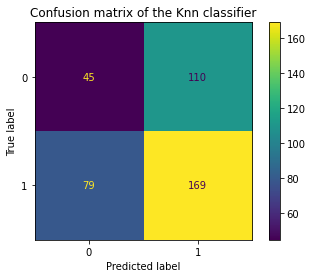

Accuracy score= 0.531


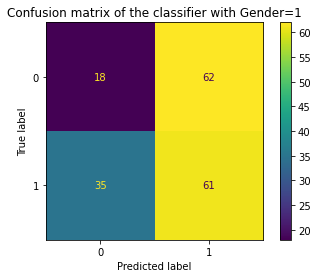

Accuracy score= 0.449


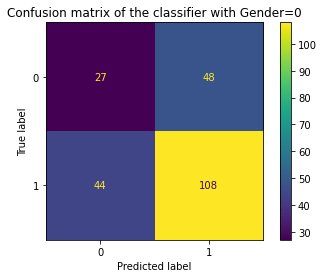

Accuracy score= 0.595
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.360                          0.225                         
2        False-positive error 0.308                          0.504                         
3        False-negative error 0.620                          0.660                         
4        EqualiZed odds(TPR)  0.380                          0.340                         
5        Conditional use accuracy equality(NPV) 0.711                          0.635                         
6        Overall accuracy equality 0.595                          0.449                         
7        Treatment equality   0.917                          0.565                         


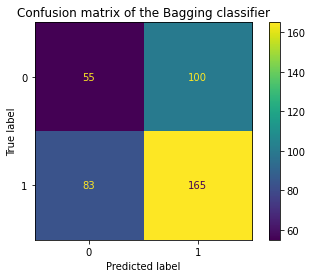

Accuracy score= 0.546


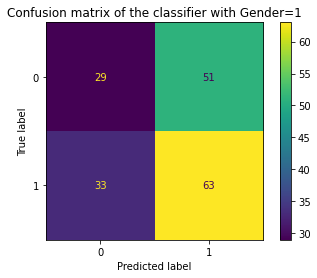

Accuracy score= 0.523


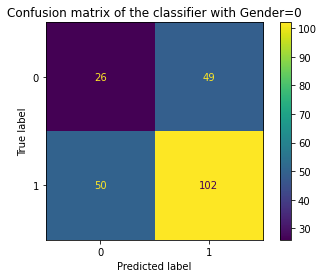

Accuracy score= 0.564
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.347                          0.362                         
2        False-positive error 0.325                          0.447                         
3        False-negative error 0.658                          0.532                         
4        EqualiZed odds(TPR)  0.342                          0.468                         
5        Conditional use accuracy equality(NPV) 0.671                          0.656                         
6        Overall accuracy equality 0.564                          0.523                         
7        Treatment equality   1.020                          0.647                         


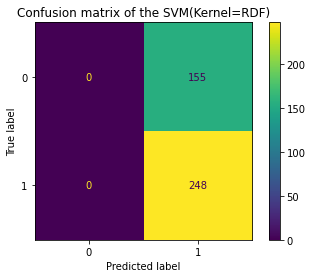

Accuracy score= 0.615


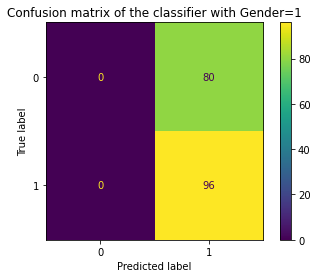

Accuracy score= 0.545


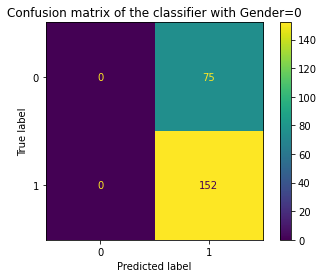

Accuracy score= 0.670
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.000                          0.000                         
2        False-positive error 0.330                          0.455                         
3        False-negative error nan                            nan                           
4        EqualiZed odds(TPR)  nan                            nan                           
5        Conditional use accuracy equality(NPV) 1.000                          1.000                         
6        Overall accuracy equality 0.670                          0.545                         
7        Treatment equality   0.000                          0.000                         


C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  FNR=FN/(TP+FN)
C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  TPR=TP/(TP+FN)


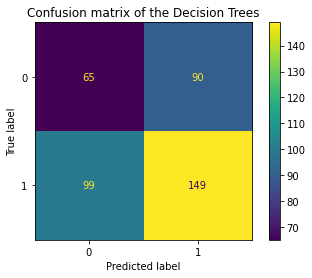

Accuracy score= 0.531


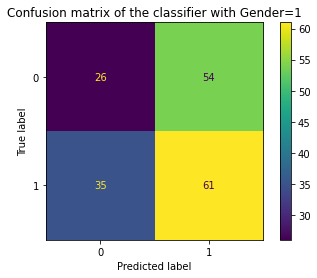

Accuracy score= 0.494


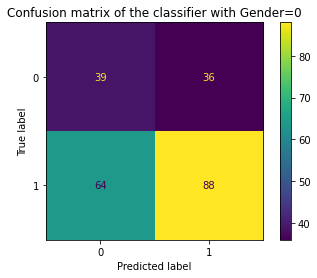

Accuracy score= 0.559
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.520                          0.325                         
2        False-positive error 0.290                          0.470                         
3        False-negative error 0.621                          0.574                         
4        EqualiZed odds(TPR)  0.379                          0.426                         
5        Conditional use accuracy equality(NPV) 0.579                          0.635                         
6        Overall accuracy equality 0.559                          0.494                         
7        Treatment equality   1.778                          0.648                         


In [17]:
Myknn(X_train,y_train,X_test,y_test)
MyBagging(X_train,y_train,X_test,y_test)
MySVC(X_train,y_train,X_test,y_test)
MyDecistionTree(X_train,y_train,X_test,y_test)

<h1> Google plus </h1>

In [18]:
def GetAttrIndex(featuresName):
    index_array=[]
    for i in range(len(featuresName)):
        if("institution:" in featuresName[0][i]):
               index_array.append(i)
    if index_array==[]:
        index_array=[0,1]
    return index_array

def InitTheAttributesGooglePlus(features,featuresName):
        edu_index=GetAttrIndex(featuresName)
        half=int(len(edu_index)/3)
        helper_features=features[[0,edu_index[0]]]
        FinalFeatures={}
        for i in range(len(features)):
            helper_features.loc[i,edu_index[0]]=0
            for j in range(edu_index[0],half):
                if features[j][i]==1:
                    helper_features.loc[i,edu_index[0]]=1
                    break
        FinalFeatures=dict(zip(features[0],helper_features[edu_index[0]]))
        return FinalFeatures


def InitTheProtectedAttributesGooglePlus(features,featuresName):
        gender_index=featuresName.index[featuresName[0]=="0 gender:1"].tolist()[0]
        features=features[[0,gender_index+1]]
        FinalFeatures=dict(zip(features[0],features[gender_index+1]))
        return FinalFeatures

def SlpitFilesGooglePlus(path):
    FeatFiles=[]
    FeatNamesFiles=[]
    EdgeFiles=[]
    for file in os.listdir(path):
        if file.endswith(".feat"):
            FeatFiles.append(file)
        elif file.endswith(".featnames"):
            FeatNamesFiles.append(file)
        elif file.endswith(".edges"):
            EdgeFiles.append(file)
    return FeatFiles,FeatNamesFiles,EdgeFiles   
    
    
def getAttributesGooglePlus(Feat,FeatNames,Edge,Range):
    MegaGooglePlus=nx.Graph()
    for i in tqdm (range(len(Range)), desc="Loading..."):
            tmpGooglePlus=nx.read_edgelist(path+Edge[i],delimiter=" ")
            tmpFeature=pd.read_csv(path+Feat[i],sep=" ",header=None)
            tmpFeatureNames=pd.read_csv(path+FeatNames[i],sep="\n",header=None)
            protectedAttr=InitTheProtectedAttributesGooglePlus(tmpFeature,tmpFeatureNames)
            nx.set_node_attributes(tmpGooglePlus,protectedAttr,"gender")
            Attr=InitTheAttributesGooglePlus(tmpFeature,tmpFeatureNames)
            nx.set_node_attributes(tmpGooglePlus,Attr,"education")
            MegaGooglePlus = nx.compose(MegaGooglePlus,tmpGooglePlus)
    return MegaGooglePlus


path= "gplus/"
Feat,FeatNames,Edge=SlpitFilesGooglePlus(path)

Range=range(0,5)
#if you want to run all the dataset of googlePlus uncomment the next line and run the function with new Range
#Range=range(0,len(Edge))

GooglePlus=getAttributesGooglePlus(Feat,FeatNames,Edge,Range)
index=np.array(list(GooglePlus.nodes()))

Loading...:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Fotis\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
Loading...: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [19]:
node2vec = Node2Vec(GooglePlus, dimensions=20, walk_length=8, num_walks=10, workers=2)

Computing transition probabilities: 100%|██████████| 4818/4818 [04:53<00:00, 16.40it/s] 


In [20]:
reformatted_walks = [list(walk) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

model = node2vec.fit(window=10, min_count=1)

Male_embeddings = np.array([model.wv[x] for x in model.wv.vocab])

In [21]:
def GetGroundTruthGooglePlus(Graph,index,GenderNameAttr,EducationNameAttr):
    Male_GroundTruht=[]
    Female_GroundTruht=[]
    CountM=0
    CountEd=0
    CountUnEd=0
    for i in range(Graph.number_of_nodes()):
        if Graph.nodes[index[i]][EducationNameAttr]==0:
            Male_GroundTruht.append(0)
            CountUnEd+=1
        elif Graph.nodes[index[i]][EducationNameAttr]==1:
            Male_GroundTruht.append(1)
            CountEd+=1
        if  Graph.nodes[index[i]][GenderNameAttr]==1:
            CountM+=1
    GenericCounts=[CountEd,CountUnEd,(Graph.number_of_nodes()-CountM),CountM] 
    return Male_GroundTruht, GenericCounts 
GroundTruht,Counts=GetGroundTruthGooglePlus(GooglePlus,index,"gender","education")

print(Counts)

k_fold = KFold(10, shuffle=True, random_state=1)

for train_index, test_index in k_fold.split(Male_embeddings):
    X_train, X_test = Male_embeddings[train_index], Male_embeddings[test_index]
    y_train, y_test = np.array(GroundTruht)[train_index], np.array(GroundTruht)[test_index]

[550, 4268, 1512, 3306]


In [22]:

def SplitGenderInTestGooglePlus(Graph,index,test):
    Male_index=[]
    Female_index=[]
    for i in range(len(test)):
        if Graph.nodes[index[test[i]]]["gender"]==1:
                Male_index.append(i)
        elif Graph.nodes[index[test[i]]]["gender"]==0:
               Female_index.append(i)
    return Male_index,Female_index

index_M,index_F=SplitGenderInTestGooglePlus(GooglePlus, index, test_index)


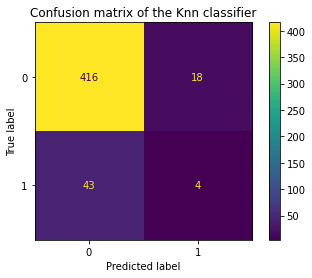

Accuracy score= 0.873


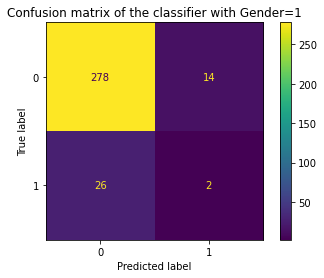

Accuracy score= 0.875


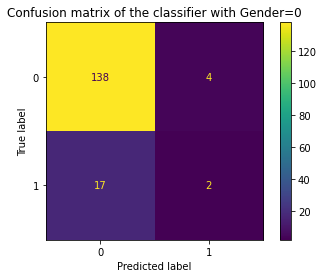

Accuracy score= 0.870
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.972                          0.952                         
2        False-positive error 0.667                          0.875                         
3        False-negative error 0.110                          0.086                         
4        EqualiZed odds(TPR)  0.890                          0.914                         
5        Conditional use accuracy equality(NPV) 0.105                          0.071                         
6        Overall accuracy equality 0.870                          0.875                         
7        Treatment equality   4.250                          1.857                         


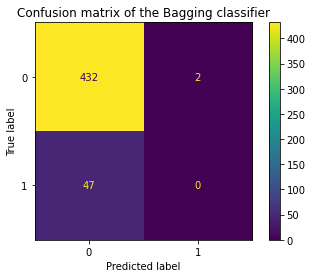

Accuracy score= 0.898


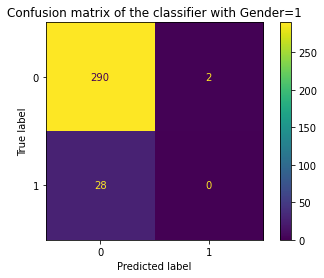

Accuracy score= 0.906


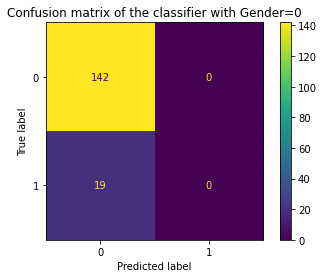

Accuracy score= 0.882
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    1.000                          0.993                         
2        False-positive error nan                            1.000                         
3        False-negative error 0.118                          0.088                         
4        EqualiZed odds(TPR)  0.882                          0.912                         
5        Conditional use accuracy equality(NPV) 0.000                          0.000                         
6        Overall accuracy equality 0.882                          0.906                         
7        Treatment equality   inf                            14.000                        


C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  FPR=FP/(TN+FP)
C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:33: RuntimeWarning: divide by zero encountered in longlong_scalars
  ScoreFairness.append(FN/FP)##3.2.7


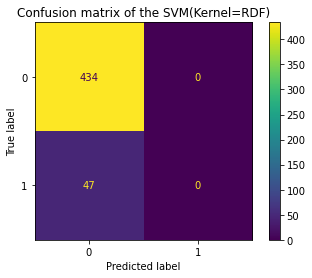

Accuracy score= 0.902


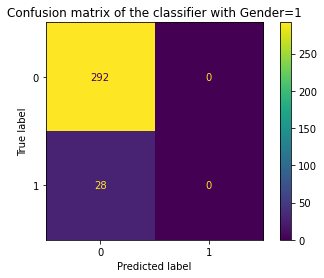

Accuracy score= 0.912


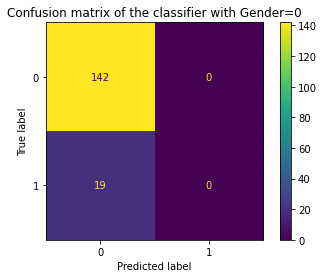

Accuracy score= 0.882
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    1.000                          1.000                         
2        False-positive error nan                            nan                           
3        False-negative error 0.118                          0.087                         
4        EqualiZed odds(TPR)  0.882                          0.912                         
5        Conditional use accuracy equality(NPV) 0.000                          0.000                         
6        Overall accuracy equality 0.882                          0.912                         
7        Treatment equality   inf                            inf                           


C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  FPR=FP/(TN+FP)
C:\Users\Fotis\AppData\Local\Temp/ipykernel_7104/3744655578.py:33: RuntimeWarning: divide by zero encountered in longlong_scalars
  ScoreFairness.append(FN/FP)##3.2.7


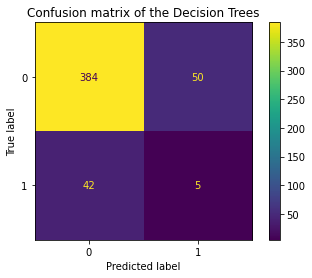

Accuracy score= 0.809


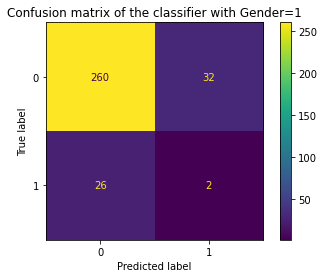

Accuracy score= 0.819


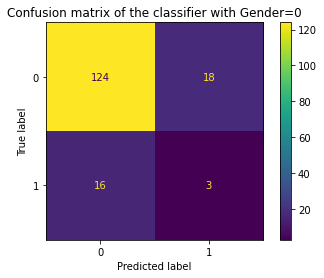

Accuracy score= 0.789
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.873                          0.890                         
2        False-positive error 0.857                          0.941                         
3        False-negative error 0.114                          0.091                         
4        EqualiZed odds(TPR)  0.886                          0.909                         
5        Conditional use accuracy equality(NPV) 0.158                          0.071                         
6        Overall accuracy equality 0.789                          0.819                         
7        Treatment equality   0.889                          0.812                         


In [23]:
Myknn(X_train,y_train,X_test,y_test)
MyBagging(X_train,y_train,X_test,y_test)
MySVC(X_train,y_train,X_test,y_test)
MyDecistionTree(X_train,y_train,X_test,y_test)

<h1> Pokec </h1>

In [24]:
#to run the full dataset Pokec With 16+ milion node uncoment the following line (estimate run time 14 hr)
#Pokec=nx.read_edgelist("pokec/soc_pokec_relationships.txt", nodetype=int, delimiter="\t")
Pokec=nx.read_edgelist("pokec/soc_pokec_relationships_small.txt", nodetype=int, delimiter="\t")
print(Pokec)

Graph with 119924 nodes and 255299 edges


In [25]:
with open("pokec/soc-pokec-profiles.txt",encoding="utf8") as f:
    lines = f.readlines()
    index=[int(line.split()[0]) for line in lines]
    protectedAttr = [int(line.split()[1]) for line in lines]
    Attr = [line.split()[3] for line in lines]

for i in range(1,len(Attr)):
    if Attr[i]=='null':
        Attr[i]=0
    else :
        Attr[i]=int(Attr[i])
    
nx.set_node_attributes(Pokec,dict(zip(index,protectedAttr)),"gender")
nx.set_node_attributes(Pokec,dict(zip(index,Attr)),"education")

index=np.array(list(Pokec.nodes()))

In [26]:
node2vec = Node2Vec(Pokec, dimensions=20, walk_length=8, num_walks=10, workers=2)

Computing transition probabilities: 100%|██████████| 119924/119924 [04:18<00:00, 464.37it/s] 
C:\Users\Fotis\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [27]:
reformatted_walks = [list(walk) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

model = node2vec.fit(window=10, min_count=1)

Male_embeddings = np.array([model.wv[x] for x in model.wv.vocab])

In [28]:
def GetGroundTruthPokec(Graph,index,GenderNameAttr,EducationNameAttr):
    Male_GroundTruht=[]
    Female_GroundTruht=[]
    CountM=0
    CountEd=0
    CountUnEd=0
    for i in range(Graph.number_of_nodes()):
        if Graph.nodes[index[i]][EducationNameAttr]==0:
            Male_GroundTruht.append(0)
            CountUnEd+=1
        elif Graph.nodes[index[i]][EducationNameAttr]==1:
            Male_GroundTruht.append(1)
            CountEd+=1
        if  Graph.nodes[index[i]][GenderNameAttr]==1:
            CountM+=1
    GenericCounts=[CountEd,CountUnEd,(Graph.number_of_nodes()-CountM),CountM] 
    return Male_GroundTruht, GenericCounts 

GroundTruht,Counts=GetGroundTruthPokec(Pokec,index,"gender","education")

print(Counts)

k_fold = KFold(10, shuffle=True, random_state=1)

for train_index, test_index in k_fold.split(Male_embeddings):
    X_train, X_test = Male_embeddings[train_index], Male_embeddings[test_index]
    y_train, y_test = np.array(GroundTruht)[train_index-1], np.array(GroundTruht)[test_index-1]

[55775, 64148, 38920, 81004]


In [29]:
def SplitGenderInTestPokec(Graph,index,test):
    Male_index=[]
    Female_index=[]
    for i in range(len(test)):
        if Graph.nodes[index[test[i]]]["gender"]==1:
                Male_index.append(i)
        elif Graph.nodes[index[test[i]]]["gender"]==0:
               Female_index.append(i)
    return Male_index,Female_index

index_M,index_F=SplitGenderInTestPokec(Pokec, index, test_index)

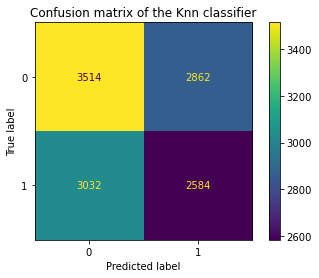

Accuracy score= 0.509


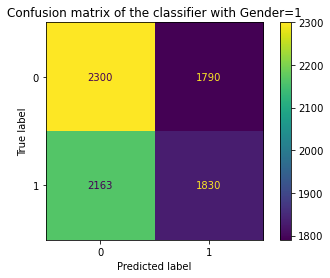

Accuracy score= 0.511


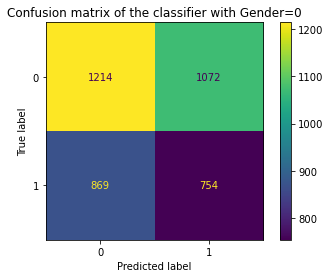

Accuracy score= 0.503
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.531                          0.562                         
2        False-positive error 0.587                          0.494                         
3        False-negative error 0.417                          0.485                         
4        EqualiZed odds(TPR)  0.583                          0.515                         
5        Conditional use accuracy equality(NPV) 0.465                          0.458                         
6        Overall accuracy equality 0.503                          0.511                         
7        Treatment equality   0.811                          1.208                         


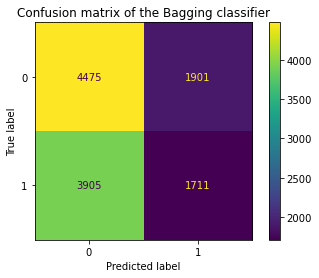

Accuracy score= 0.516


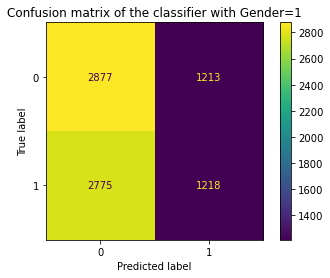

Accuracy score= 0.507


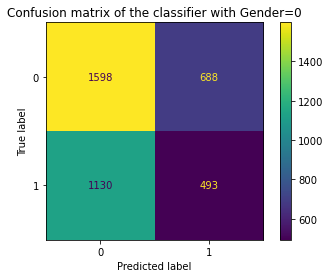

Accuracy score= 0.535
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.699                          0.703                         
2        False-positive error 0.583                          0.499                         
3        False-negative error 0.414                          0.491                         
4        EqualiZed odds(TPR)  0.586                          0.509                         
5        Conditional use accuracy equality(NPV) 0.304                          0.305                         
6        Overall accuracy equality 0.535                          0.507                         
7        Treatment equality   1.642                          2.288                         


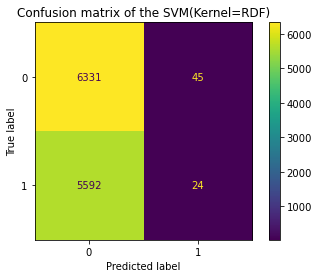

Accuracy score= 0.530


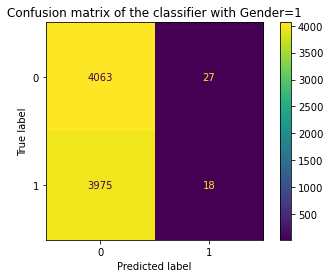

Accuracy score= 0.505


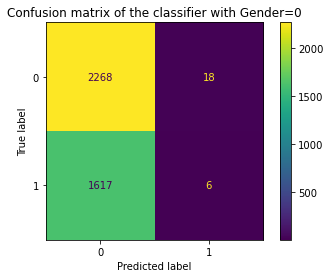

Accuracy score= 0.582
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.992                          0.993                         
2        False-positive error 0.750                          0.600                         
3        False-negative error 0.416                          0.495                         
4        EqualiZed odds(TPR)  0.584                          0.505                         
5        Conditional use accuracy equality(NPV) 0.004                          0.005                         
6        Overall accuracy equality 0.582                          0.505                         
7        Treatment equality   89.833                         147.222                       


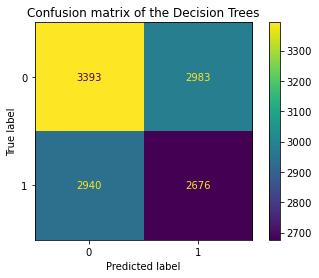

Accuracy score= 0.506


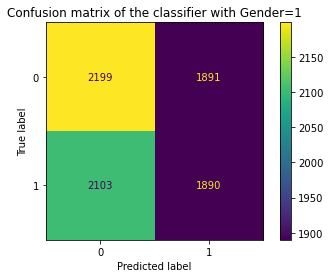

Accuracy score= 0.506


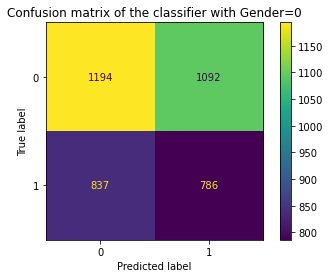

Accuracy score= 0.507
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.522                          0.538                         
2        False-positive error 0.581                          0.500                         
3        False-negative error 0.412                          0.489                         
4        EqualiZed odds(TPR)  0.588                          0.511                         
5        Conditional use accuracy equality(NPV) 0.484                          0.473                         
6        Overall accuracy equality 0.507                          0.506                         
7        Treatment equality   0.766                          1.112                         


In [30]:
Myknn(X_train,y_train,X_test,y_test)
MyBagging(X_train,y_train,X_test,y_test)
MySVC(X_train,y_train,X_test,y_test)
MyDecistionTree(X_train,y_train,X_test,y_test)

<h1> Twitch </h1>

In [31]:
Twitch=nx.read_edgelist("twitch/ENGB/musae_ENGB_edges.csv", nodetype=int, delimiter=",")
print(Twitch)

Graph with 7126 nodes and 35324 edges


In [32]:
tmpFeature=pd.read_csv("twitch/ENGB//musae_ENGB_target.csv",sep=",",header=None)
countT=0
countF=0
Attr=tmpFeature[1]
protectedAttr=tmpFeature[2]
for i in range(len(tmpFeature)):
    protectedAttr.loc[i]=int(tmpFeature[2][i])
    if tmpFeature[1][i]>1500:
        countT+=1
        #Attr.append([tmpFeature[0][i],1])
        Attr.loc[i]=1
    else:
        countF+=1
       # Attr.append([tmpFeature[0][i],0])
        Attr.loc[i]=0
         
nx.set_node_attributes(Twitch,protectedAttr,"mature")
nx.set_node_attributes(Twitch,Attr,"views")

C:\Users\Fotis\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
node2vec = Node2Vec(Twitch, dimensions=20, walk_length=8, num_walks=10, workers=2)

Computing transition probabilities: 100%|██████████| 7126/7126 [00:08<00:00, 843.80it/s] 


In [34]:
reformatted_walks = [list(walk) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

model = node2vec.fit(window=10, min_count=1)

Male_embeddings = np.array([model.wv[x] for x in model.wv.vocab])

In [35]:
GroundTruht,Counts=InitEducationGroundTruth(Twitch,"mature","views")

print(Counts)

k_fold = KFold(10, shuffle=True, random_state=1)

for train_index, test_index in k_fold.split(Male_embeddings):
    X_train, X_test = Male_embeddings[train_index], Male_embeddings[test_index]
    y_train, y_test = np.array(GroundTruht)[train_index], np.array(GroundTruht)[test_index]

[3681, 3445, 3237, 3889]


In [36]:
index_M,index_F=SplitGenderInTest(Twitch,test_index,"mature")

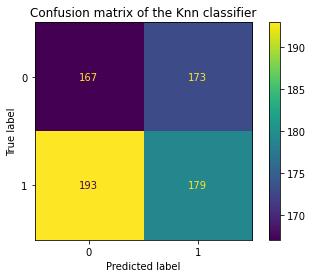

Accuracy score= 0.486


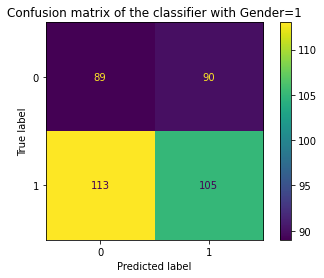

Accuracy score= 0.489


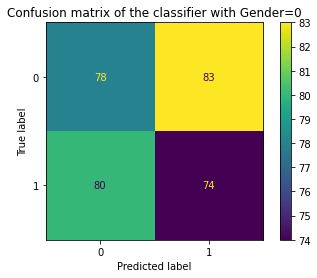

Accuracy score= 0.483
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.484                          0.497                         
2        False-positive error 0.529                          0.462                         
3        False-negative error 0.506                          0.559                         
4        EqualiZed odds(TPR)  0.494                          0.441                         
5        Conditional use accuracy equality(NPV) 0.481                          0.482                         
6        Overall accuracy equality 0.483                          0.489                         
7        Treatment equality   0.964                          1.256                         


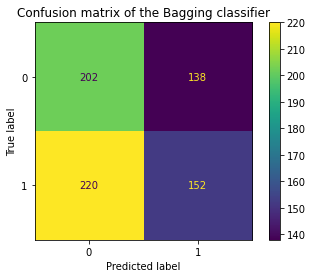

Accuracy score= 0.497


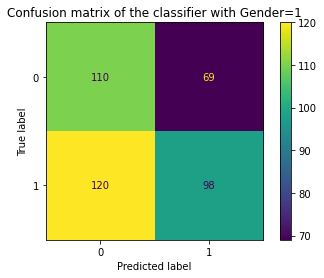

Accuracy score= 0.524


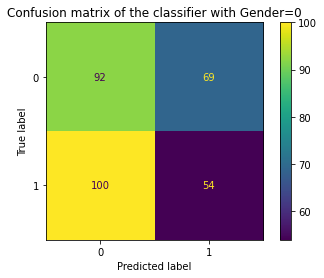

Accuracy score= 0.463
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.571                          0.615                         
2        False-positive error 0.561                          0.413                         
3        False-negative error 0.521                          0.522                         
4        EqualiZed odds(TPR)  0.479                          0.478                         
5        Conditional use accuracy equality(NPV) 0.351                          0.450                         
6        Overall accuracy equality 0.463                          0.524                         
7        Treatment equality   1.449                          1.739                         


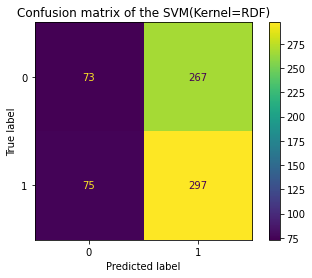

Accuracy score= 0.520


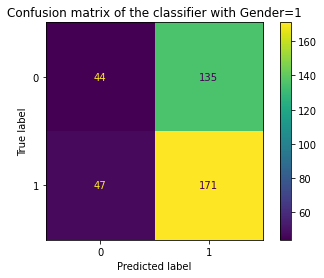

Accuracy score= 0.542


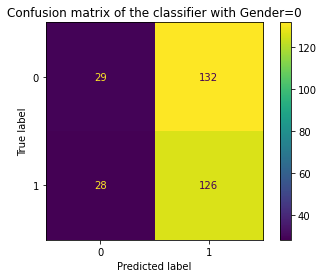

Accuracy score= 0.492
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.180                          0.246                         
2        False-positive error 0.512                          0.441                         
3        False-negative error 0.491                          0.516                         
4        EqualiZed odds(TPR)  0.509                          0.484                         
5        Conditional use accuracy equality(NPV) 0.818                          0.784                         
6        Overall accuracy equality 0.492                          0.542                         
7        Treatment equality   0.212                          0.348                         


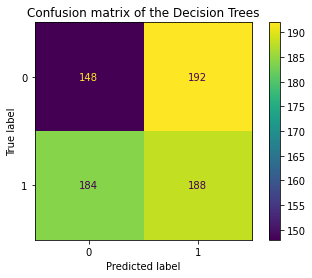

Accuracy score= 0.472


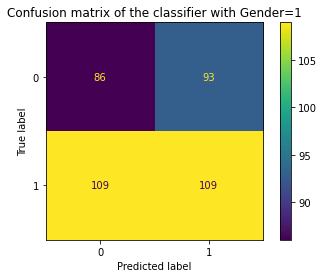

Accuracy score= 0.491


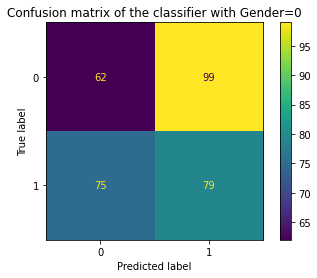

Accuracy score= 0.448
Pos      Name of Defenition   Score with G=0                 Score with G=1                
1        Predictive parity    0.385                          0.480                         
2        False-positive error 0.556                          0.460                         
3        False-negative error 0.547                          0.559                         
4        EqualiZed odds(TPR)  0.453                          0.441                         
5        Conditional use accuracy equality(NPV) 0.513                          0.500                         
6        Overall accuracy equality 0.448                          0.491                         
7        Treatment equality   0.758                          1.172                         


In [37]:
Myknn(X_train,y_train,X_test,y_test)
MyBagging(X_train,y_train,X_test,y_test)
MySVC(X_train,y_train,X_test,y_test)
MyDecistionTree(X_train,y_train,X_test,y_test)